In [1]:
import json, random
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from PIL import Image
import numpy as np
import os


In [2]:
import os, pathlib

base = pathlib.Path("/kaggle/input/detect-cracks")
# top-level dirs/files
for p in base.iterdir():
    print(("DIR " if p.is_dir() else "FILE"), p.name)

# only directories (one level)
dirs = [p for p in base.iterdir() if p.is_dir()]
print([d.name for d in dirs])


DIR  cracks.v1i.coco
DIR  Drywall-Join-Detect.v2i.coco
['cracks.v1i.coco', 'Drywall-Join-Detect.v2i.coco']


**Visulaizing a few images on the notebook** 

In [3]:
def visualize_coco_images(data_dir, ann_file, num_samples=3):
    """
    Display a few random COCO images with bbox + segmentation (if available)
    """
    coco = COCO(ann_file)
    img_ids = coco.getImgIds()
    sample_ids = random.sample(img_ids, num_samples)

    for img_id in sample_ids:
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(data_dir, img_info['file_name'])
        anns = coco.loadAnns(coco.getAnnIds(imgIds=img_id))

        # Load image
        img = np.array(Image.open(img_path).convert("RGB"))

        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis("off")

        # Draw segmentation if available, else just bbox
        for ann in anns:
            bbox = ann['bbox']
            plt.gca().add_patch(plt.Rectangle(
                (bbox[0], bbox[1]), bbox[2], bbox[3],
                fill=False, color='lime', linewidth=2
            ))

            if 'segmentation' in ann and ann['segmentation']:
                coco.showAnns([ann], draw_bbox=False)
            else:
                plt.text(bbox[0], bbox[1]-5, "BBox only", color='yellow', fontsize=9)

        plt.title(img_info['file_name'])
        plt.show()


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


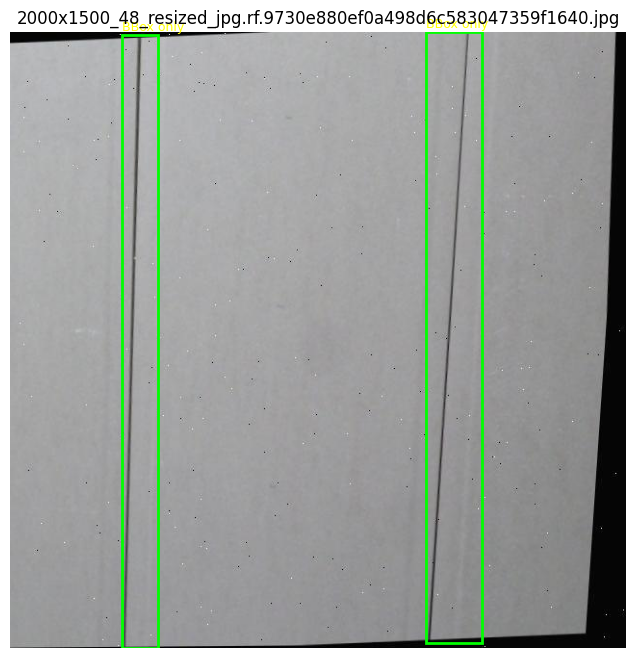

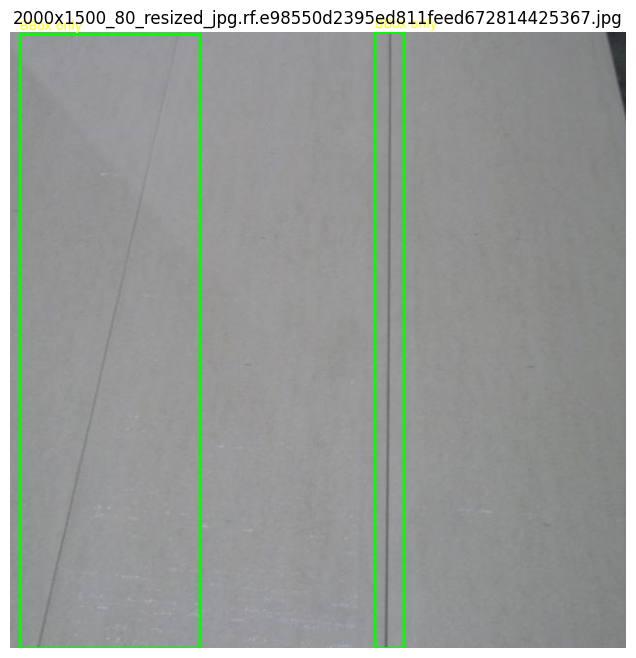

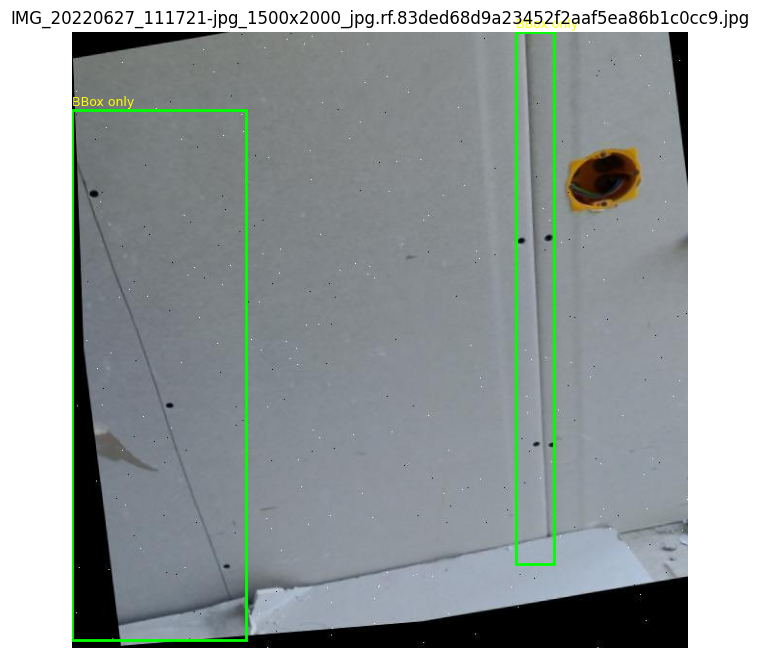

In [4]:
train_dir1 = "/kaggle/input/detect-cracks/Drywall-Join-Detect.v2i.coco/train"
train_ann1 = os.path.join(train_dir1, "_annotations.coco.json")  # or your actual annotation filename

visualize_coco_images(train_dir1, train_ann1, num_samples=3)


loading annotations into memory...
Done (t=0.61s)
creating index...
index created!


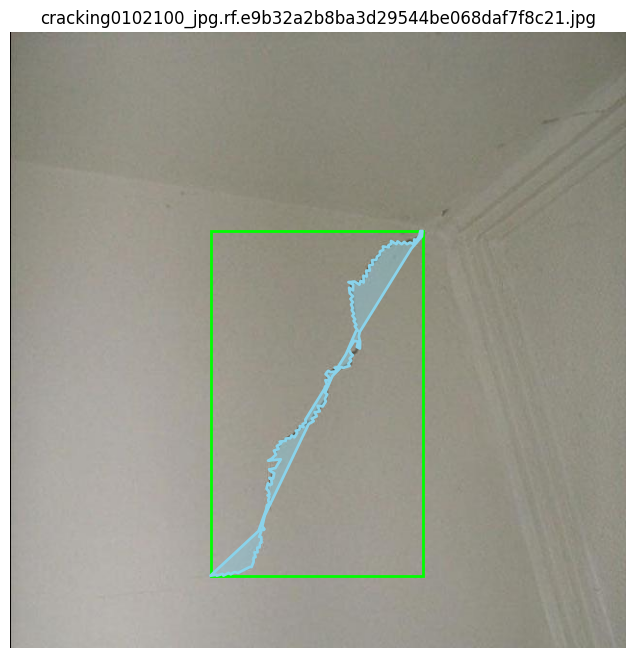

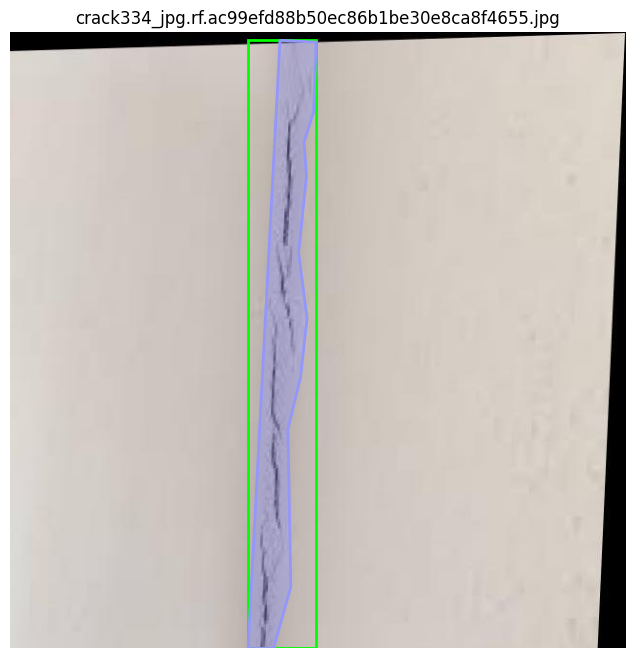

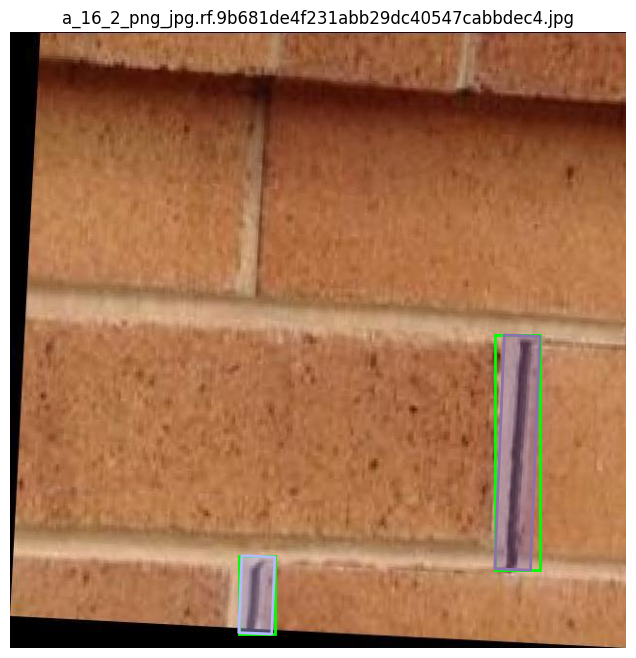

In [5]:
train_dir2 = "/kaggle/input/detect-cracks/cracks.v1i.coco/train"
train_ann2 = os.path.join(train_dir2, "_annotations.coco.json")  # or your actual annotation filename

visualize_coco_images(train_dir2, train_ann2, num_samples=3)


**SAM large model to generate seg masks from bbox**

In [6]:
import cv2
import torch, numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from transformers import SamModel, SamProcessor
import matplotlib.patches as patches


2025-10-25 15:10:12.813463: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761405013.043015      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761405013.101407      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = SamProcessor.from_pretrained("facebook/sam-vit-large")
model = SamModel.from_pretrained("facebook/sam-vit-large").to(device).eval()

model.eval()

img_dir  = "/kaggle/input/detect-cracks/Drywall-Join-Detect.v2i.coco/train"
ann_file = os.path.join(img_dir, "_annotations.coco.json") 

coco = COCO(ann_file)
img_ids = random.sample(coco.getImgIds(), 3)




preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [8]:
## preprocessing functions

def coco_bbox_to_xyxy(b):
    x,y,w,h = b
    return [x, y, x+w, y+h]


def edge_refine_mask_cv2(image_rgb, bin_mask, box,
                         canny_low=60, canny_high=140,
                         band_px=None, min_area=80, connect_px=3):
    """
    Edge-aware refinement inside the bbox ROI only, with ridge cues + directional closing.
    Returns np.uint8(H,W) in {0,1}, clipped to bbox.
    """
    import cv2, numpy as np

    H, W = bin_mask.shape
    x0, y0, x1, y1 = map(int, box)
    x0, y0 = max(0, x0), max(0, y0); x1, y1 = min(W, x1), min(H, y1)
    if x1 <= x0 or y1 <= y0:  # degenerate
        out = np.zeros_like(bin_mask); return out

    roi_img  = image_rgb[y0:y1, x0:x1]
    roi_mask = bin_mask[y0:y1, x0:x1].astype(np.uint8)

    # --- grayscale + contrast + denoise ---
    g = cv2.cvtColor(roi_img, cv2.COLOR_RGB2GRAY)
    g = cv2.bilateralFilter(g, 5, 25, 25)
    g = cv2.createCLAHE(2.0, (8,8)).apply(g)

    # --- edges + ridges (Scharr magnitude) ---
    edges = cv2.Canny(g, canny_low, canny_high)
    gx = cv2.Scharr(g, cv2.CV_32F, 1, 0); gy = cv2.Scharr(g, cv2.CV_32F, 0, 1)
    mag = cv2.magnitude(gx, gy); mag = mag / (mag.max() + 1e-6)
    thr = np.quantile(mag[roi_mask > 0], 0.80) if roi_mask.any() else 0.80
    ridges = (mag >= thr).astype(np.uint8) * 255

    # --- distance band around (edges ∪ ridges) ---
    cues = cv2.bitwise_or(edges, ridges)
    dist = cv2.distanceTransform(cv2.bitwise_not(cues), cv2.DIST_L2, 5)
    if band_px is None:
        band_px = max(3, int(0.06 * min(y1 - y0, x1 - x0)))  # auto band ~6% of short side
    band = (dist <= float(band_px)).astype(np.uint8)

    refined = (roi_mask & band)

    # --- connect fragments (directional + isotropic close) ---
    klen = max(3, 2 * connect_px + 1)
    vert = (y1 - y0) >= (x1 - x0)
    k_dir = cv2.getStructuringElement(cv2.MORPH_RECT, (1, klen) if vert else (klen, 1))
    refined = cv2.morphologyEx(refined, cv2.MORPH_CLOSE, k_dir, iterations=1)
    k_iso = cv2.getStructuringElement(cv2.MORPH_RECT, (connect_px, connect_px))
    refined = cv2.morphologyEx(refined, cv2.MORPH_CLOSE, k_iso, iterations=1)

    # --- drop tiny blobs (relative to box) ---
    rel_min = max(min_area, int(0.003 * (x1 - x0) * (y1 - y0)))
    num, labels, stats, _ = cv2.connectedComponentsWithStats(refined, connectivity=8)
    keep = np.zeros_like(refined)
    for cid in range(1, num):
        if stats[cid, cv2.CC_STAT_AREA] >= rel_min:
            keep[labels == cid] = 1

    out = np.zeros_like(bin_mask); out[y0:y1, x0:x1] = keep
    return out


In [9]:


#  visualization
def visualize_sam_masks(img_ids, coco, threshold=0.5):
    for img_id in img_ids:
        info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(img_dir, info["file_name"])
        image = np.array(Image.open(img_path).convert("RGB"))

        anns = coco.loadAnns(coco.getAnnIds(imgIds=img_id))
        if not anns:
            continue

        boxes_xyxy = [[[float(x) for x in coco_bbox_to_xyxy(a["bbox"])] for a in anns]]

        # run SAM
        inputs = processor(images=image, input_boxes=boxes_xyxy, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)

        masks = processor.post_process_masks(
            outputs.pred_masks, inputs["original_sizes"], inputs["reshaped_input_sizes"]
        )[0]
        ious = outputs.iou_scores[0]

        best_idx = ious.argmax(dim=-1)
        best_masks = masks[torch.arange(masks.shape[0]), best_idx]

        # convert → binary numpy mask
        binary = (best_masks.sigmoid() > threshold).cpu().numpy().astype(np.uint8)

        # apply edge refinement per box
        refined_list = []
        for i, b in enumerate(boxes_xyxy[0]):
            refined_mask = edge_refine_mask_cv2(image, binary[i], b)
            refined_list.append(refined_mask)
        m = np.max(refined_list, axis=0)


        print(info["file_name"])

        # visualization
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        ax = plt.gca()
        for b in boxes_xyxy[0]:
            x0, y0, x1, y1 = b
            ax.add_patch(patches.Rectangle(
                (x0, y0), x1 - x0, y1 - y0,
                fill=False, edgecolor='lime', linewidth=2
            ))
        plt.imshow(m, cmap="Blues", alpha=0.4)
        plt.axis("off")
        plt.title(info["file_name"])
        plt.show()


IMG_8207_JPG_jpg.rf.ece672972889541e4b9df796ad21a49f.jpg


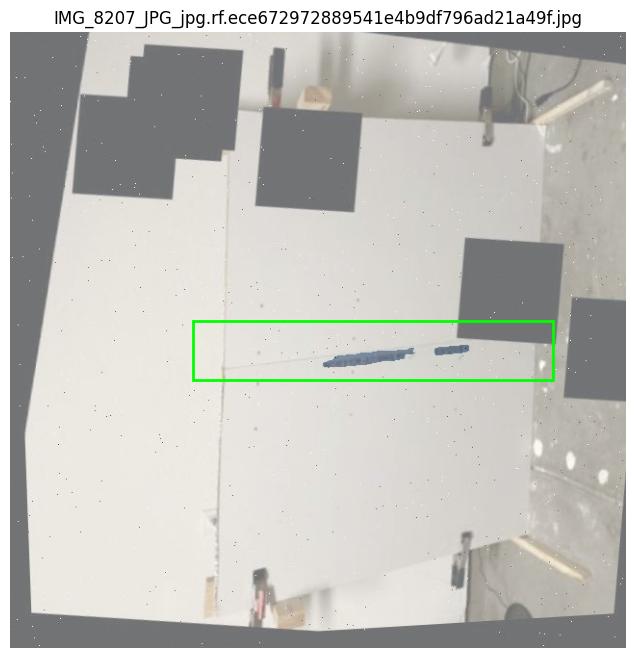

IMG_20220627_111720-jpg_1500x2000_jpg.rf.d12645951ce79b6ef84f111425667f55.jpg


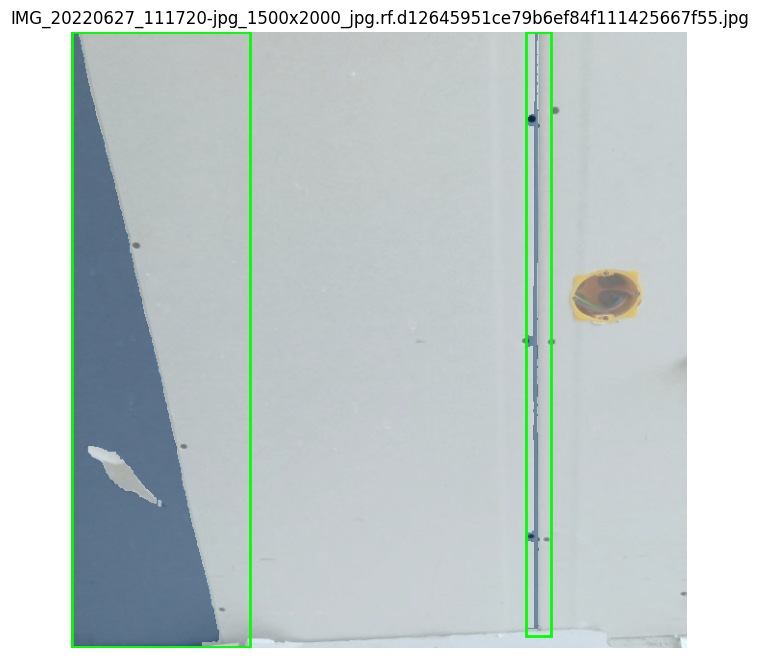

IMG_8220_JPG_jpg.rf.4559ff9081339e81c71ebba08eaacdd4.jpg


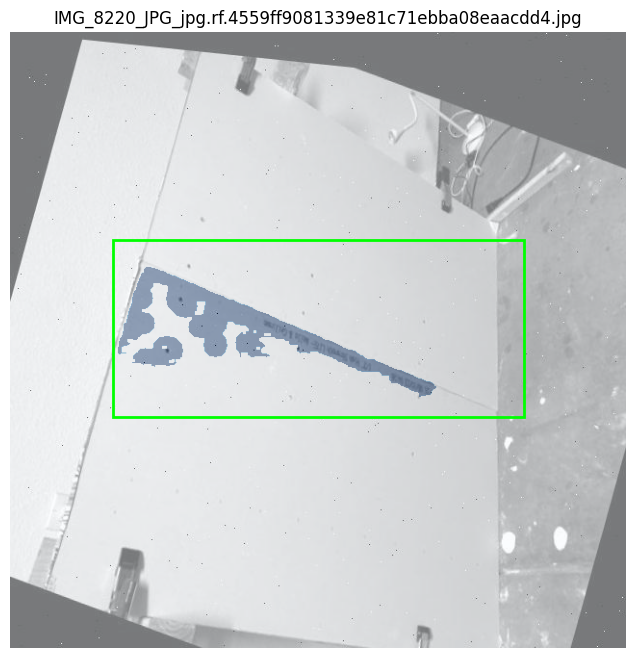

In [10]:
img_ids = random.sample(coco.getImgIds(), 3)

visualize_sam_masks(img_ids, coco, threshold=0.5)

In [11]:
import os, json, cv2, numpy as np, torch
from pycocotools.coco import COCO
from tqdm import tqdm

def generate_refined_coco_masks(coco_ann_path, img_dir, threshold=0.5, train_or_val="train"):
    """
    Run SAM + edge refinement on all COCO images and save new segmentations only.
    """
    coco = COCO(coco_ann_path)
    img_ids = coco.getImgIds()[0:100]
    refined_masks_per_img = []

    for img_id in tqdm(img_ids, desc="Processing images", unit="img"):

        info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(img_dir, info["file_name"])
        if not os.path.exists(img_path):
            continue

        image = np.array(Image.open(img_path).convert("RGB"))
        anns = coco.loadAnns(coco.getAnnIds(imgIds=img_id))
        if not anns:
            continue

        boxes_xyxy = [[[float(x) for x in coco_bbox_to_xyxy(a["bbox"])] for a in anns]]
        inputs = processor(images=image, input_boxes=boxes_xyxy, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model(**inputs)

        masks = processor.post_process_masks(
            outputs.pred_masks, inputs["original_sizes"], inputs["reshaped_input_sizes"]
        )[0]
        ious = outputs.iou_scores[0]
        best_idx = ious.argmax(dim=-1)
        best_masks = masks[torch.arange(masks.shape[0]), best_idx]
        binary = (best_masks.sigmoid() > threshold).cpu().numpy().astype(np.uint8)

        refined_list = []
        for i, b in enumerate(boxes_xyxy[0]):
            refined_mask = edge_refine_mask_cv2(image, binary[i], b)
            refined_list.append(refined_mask)

        refined_masks_per_img.append(refined_list)

    # --- save only new segmentations ---
    with open(coco_ann_path, "r") as f:
        data = json.load(f)

    anns_by_img = {a["image_id"]: [] for a in data["annotations"]}
    for a in data["annotations"]:
        anns_by_img[a["image_id"]].append(a)

    for img_id, mask_list in zip(img_ids, refined_masks_per_img):
        anns = anns_by_img.get(img_id, [])
        if not anns:
            continue

        for ann, m in zip(anns, mask_list):
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            polygons = [c.reshape(-1).tolist() for c in contours if len(c) >= 6]
            if not polygons:
                continue

            ann["segmentation"] = polygons

    out_dir = "/kaggle/working"
    out_name = f"taping_segment_{train_or_val}_100" + os.path.basename(coco_ann_path).replace(".json", "_refined.json")
    out_path = os.path.join(out_dir, out_name)

    with open(out_path, "w") as f:
        json.dump(data, f, indent=2)

    print(f"✅ Refined COCO file saved → {out_path}")


In [12]:

img_dir = "/kaggle/input/detect-cracks/Drywall-Join-Detect.v2i.coco/train"
coco_ann_path = os.path.join(img_dir, "_annotations.coco.json")  # or your actual annotation filename

generate_refined_coco_masks(coco_ann_path, img_dir, train_or_val="train")

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


Processing images: 100%|██████████| 100/100 [02:03<00:00,  1.23s/img]

✅ Refined COCO file saved → /kaggle/working/taping_segment_train_100_annotations.coco_refined.json


In [115]:

img_dir = "/kaggle/input/detect-cracks/Drywall-Join-Detect.v2i.coco/valid"
coco_ann_path = os.path.join(img_dir, "_annotations.coco.json")  # or your actual annotation filename

generate_refined_coco_masks(coco_ann_path, img_dir, train_or_val="val")

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


Processing images:   0%|          | 0/202 [00:00<?, ?img/s]

0 images processed


Processing images:  50%|████▉     | 100/202 [02:07<02:11,  1.29s/img]

100 images processed


Processing images:  99%|█████████▉| 200/202 [04:15<00:02,  1.28s/img]

200 images processed


Processing images: 100%|██████████| 202/202 [04:17<00:00,  1.28s/img]

✅ Refined COCO file saved → /kaggle/working/taping_segment_val_annotations.coco_refined.json


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


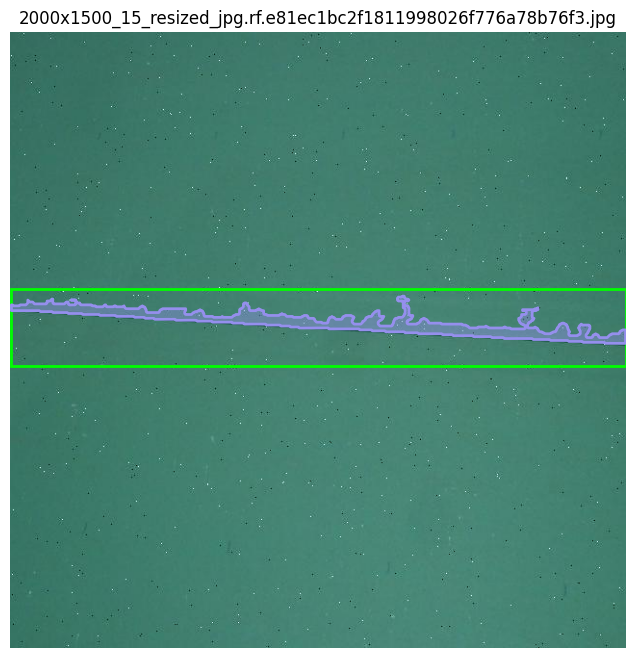

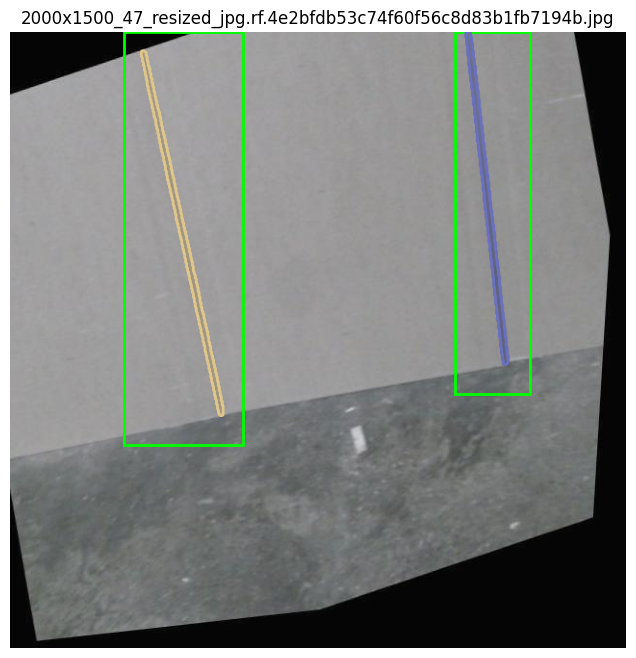

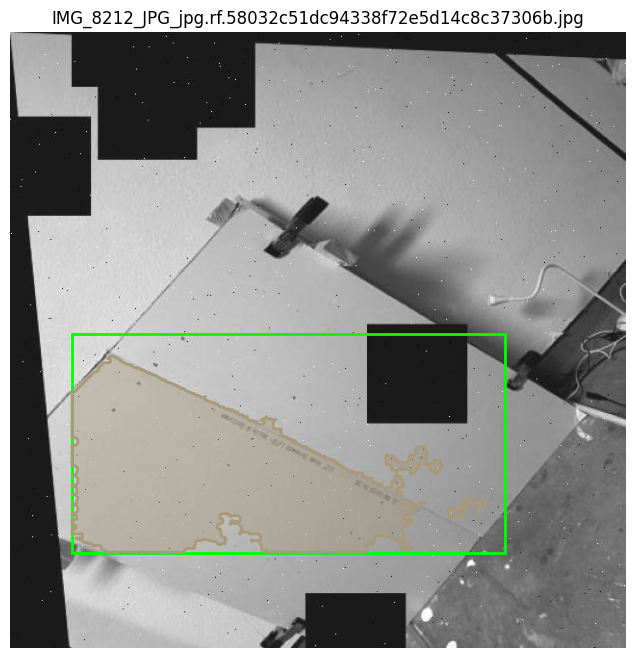

In [124]:

img_dir = "/kaggle/input/detect-cracks/Drywall-Join-Detect.v2i.coco/valid"
coco_ann_path = "/kaggle/working/taping_segment_val_annotations.coco_refined.json"

visualize_coco_images(img_dir, coco_ann_path, num_samples=3)


